<a href="https://colab.research.google.com/github/HarlinLee/BlobOT/blob/main/acceleration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
DRIVE_PATH = "/content/drive/MyDrive/BlobOT-final"

import sys
sys.path.insert(0, DRIVE_PATH)

import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle

import datetime
date = datetime.datetime.today().strftime("%y%m%d")
print(date)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
230529


In [ ]:
if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
 dev = "cpu" 
device = torch.device(dev) 
print(device)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

cpu
Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
from BlobOT import KE_acc, NLE_acc, NLE_acc_pos, Model
from BlobOT import draw_straight_lines, EarlyStopping

def blobLoss(X, model, positive=False):
  if not positive:
    return KE_acc(X, model.z, model.params) + NLE_acc(X, model.w, model.params)
  else:
    return KE_acc(X, model.z, model.params) + NLE_acc_pos(X, model.w, model.params)


def training_loop(model, optimizer, n=10000):
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True,
                                                         patience=2, threshold=0,
                                                         factor=0.2)
  early_stopping = EarlyStopping(patience=5)

  losses=[]
  res = {}

  for i in range(1, 1+n):
    preds = model()
    loss = blobLoss(preds, model, positive=True)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    scheduler.step(loss)
    early_stopping(loss)
    losses.append(loss.cpu().detach().numpy())

    if early_stopping.early_stop:
      print("Early stopping at", i, 'out of', n)
      return np.array(losses), res
    
    if i in [int(1e3), int(1e4), 2*int(1e4), 5*int(1e4)] or i % int(1e5)==0:
      print(i)
      X = preds.cpu().detach().numpy()
      res[str(i)] = X
      plot_one_run(X)

  return np.array(losses), res



In [ ]:
def plot_one_run(X):
  
  # plot particle trajectory
  y = X[:, :, -1]
  fig, ax = plt.subplots(1, 2)

  if X.shape[-1] <= params['L']-1:
    X = np.concatenate((z, X), axis=-1)

  t = params['dt']*np.arange(params['L']+1)

  for p in range(X.shape[0]):
    traj = X[p].T
    ax[0].plot(traj[:, 0], t,  color=[.5, .5, 1])

  ax[0].scatter(X[:, 0, 0], np.zeros_like(X[:, 0, 0]), marker='+', c='b', label='Source')
  ax[0].scatter(x1[:, 0], 1 + np.zeros_like(x1[:, 0]), marker='x', c='r', label='Target')
  ax[0].scatter(y[:, 0], 1 + np.zeros_like(y[:, 0]), marker='.', c='k', label='x(1)')

  # zoom panel
  for p in range(X.shape[0]):
    traj = X[p].T
    ax[1].plot(traj[-2:, 0], t[-2:],  color=[.5, .5, 1])

  ax[1].scatter(x1[:, 0], 1 + np.zeros_like(x1[:, 0]), marker='x', c='r', label='Target')
  for p in range(params['N']):
    ax[1].plot((x1[p], x1[p]-dt*v1[p]), (1, 1-dt), 'r:')
  
  ax[1].scatter(y[:, 0], 1 + np.zeros_like(y[:, 0]), marker='.', c='k', label='x(1)')

  plt.show()

In [ ]:
d = 1
dt = 0.1
L = int(1/dt)

N = 10

eps = 1e-3

delta = N**(-0.99/(d+1))

params = {'d': d, 'dt': dt, 'L': L, 'N': N, 'delta': delta, 'eps': eps}

# source x(0), v(0)
x0 = np.linspace(0, 1, num=N).reshape(N, d)
v0 = np.zeros_like(x0)

# particle positions for the first two time steps are fixed
# x(dt) = x(0) + dt*v(0)
x_dt = x0 + v0*dt
z = np.expand_dims(np.concatenate((x0, x_dt), axis=-1), axis=1) 

z_tensor = torch.from_numpy(z.astype(np.float64)).to(device)

## Grid target velocity

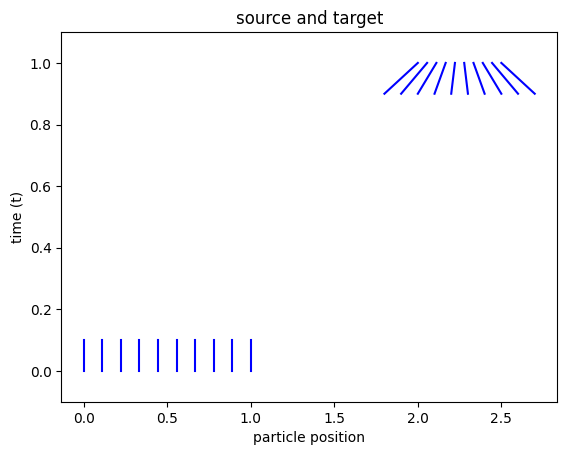

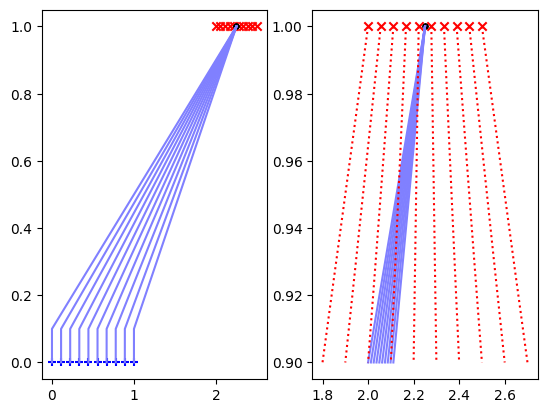

{'d': 1, 'dt': 0.1, 'L': 10, 'N': 10, 'delta': 0.3198895109691398, 'eps': 0.001, 'lr': 4e-06, 'n': 1000000}
1000


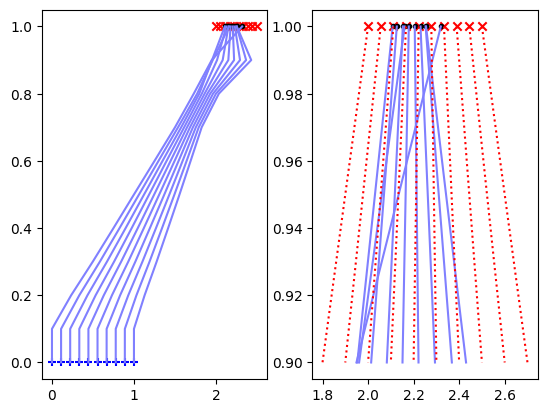

10000


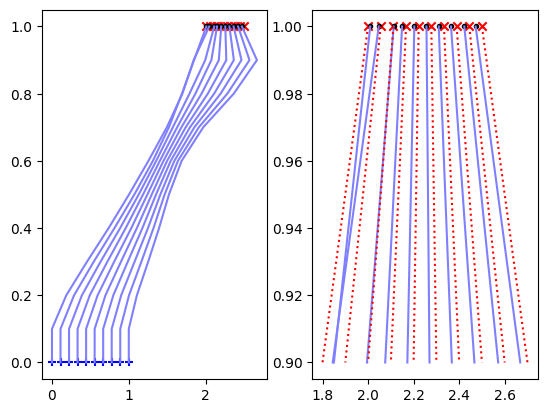

20000


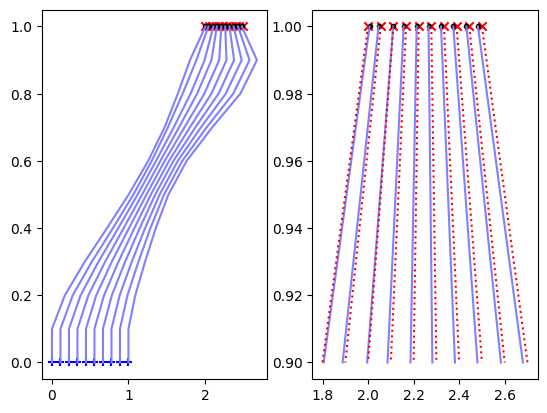

50000


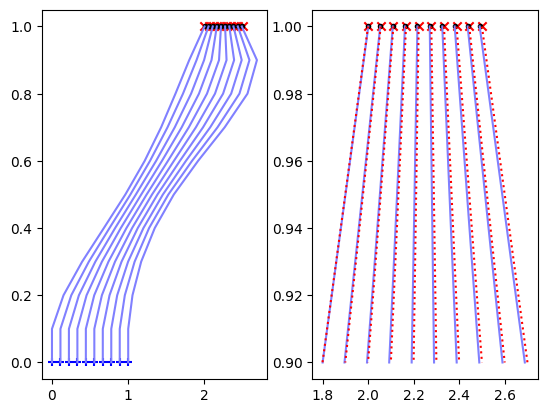

100000


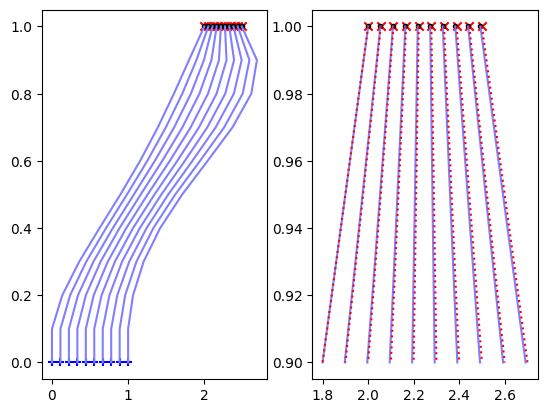

200000


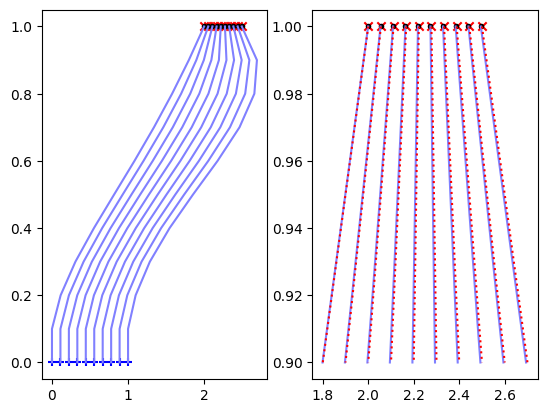

300000


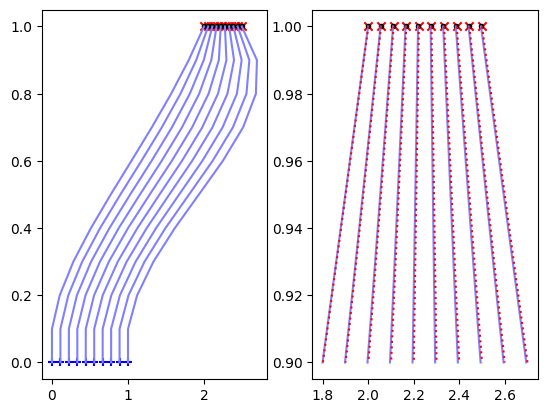

400000


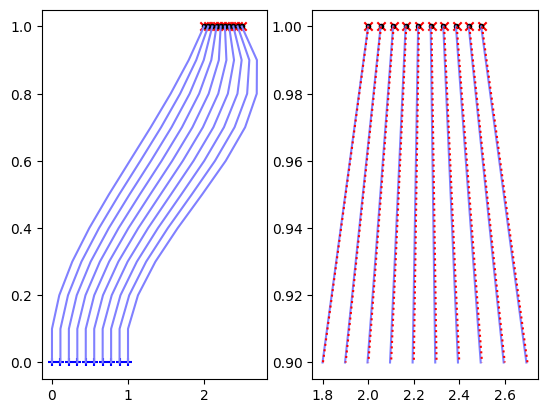

500000


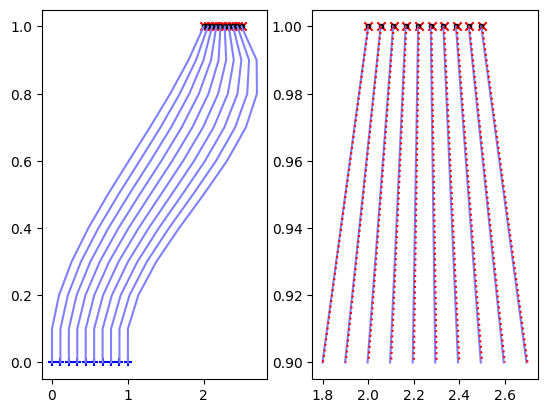

600000


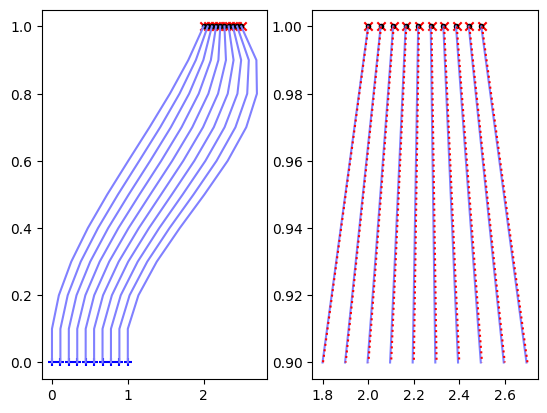

700000


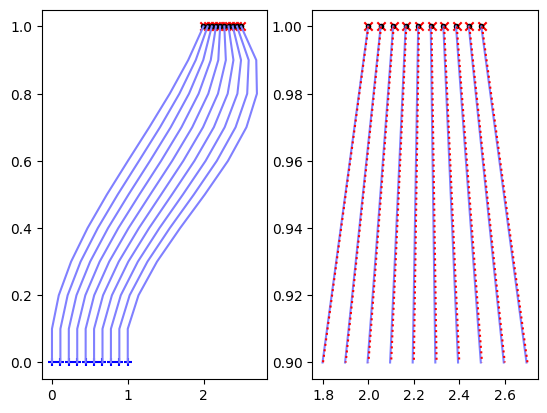

800000


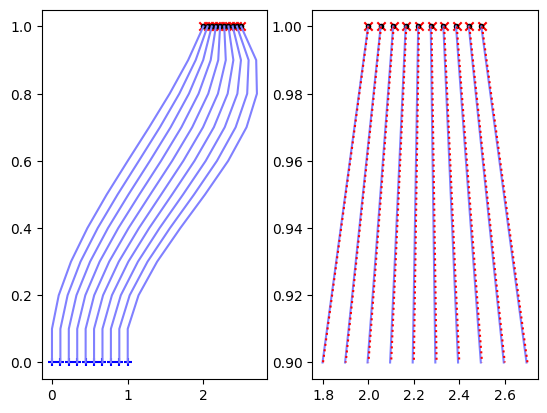

900000


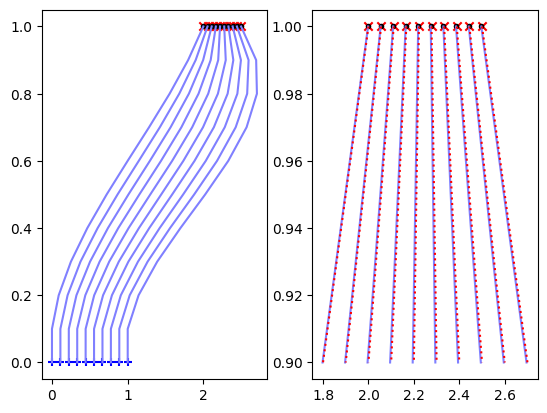

1000000


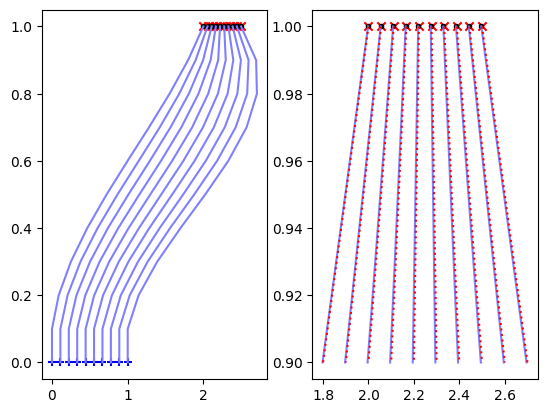

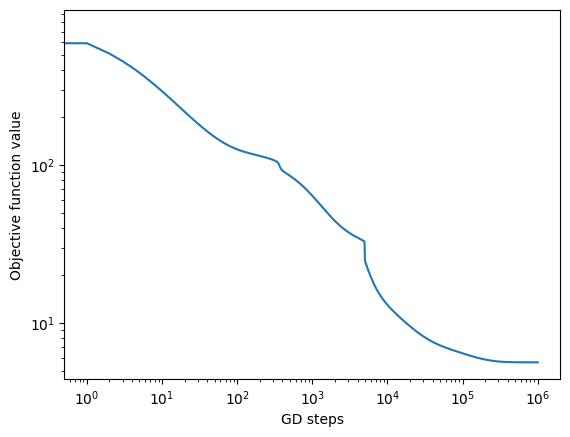

In [ ]:
lr = 4*eps/1e3
gd_steps = int(1e6)

params.update({'lr': lr, 'n': gd_steps})

# target x(1), v(1)
x1 = np.linspace(2, 2.5, num=N).reshape(N, d)
v1 = np.linspace(-2, 2, num=N).reshape(N, d)[::-1]

w_tensor = torch.from_numpy(np.concatenate((x1, v1), axis=-1).astype(np.float64)).to(device)

# plot source and target
for p in range(N):
  plt.plot((x0[p], x_dt[p]), (0, dt), 'b')
  plt.plot((x1[p], x1[p]-dt*v1[p]), (1, 1-dt), 'b')
plt.title(r'source and target')
plt.ylabel('time (t)')
plt.xlabel('particle position')
plt.ylim([-dt, 1+dt])
plt.show()

# initialize at the middle
y0 = np.mean(x1)*np.ones_like(x1)
X0 = draw_straight_lines(x_dt, y0, params['L'])

plot_one_run(X0)


print(params)

# run gradient descent
m = Model(torch.from_numpy(X0.astype(np.float64)).to(device), w_tensor, z_tensor, params)
opt = torch.optim.SGD(m.parameters(), lr=params['lr'])
losses, res = training_loop(m, opt, n=params['n'])

X = m.X.data.cpu().detach().numpy()

# plot loss
plt.plot(losses)
plt.xlabel('GD steps')
plt.ylabel('Objective function value')
plt.xscale('log')
plt.yscale('log')
plt.show()

# save results
res[str(0)] = X0
res[str(gd_steps)] = X
res.update({'losses': losses, 'params': params, 'x0': x0, 'v0': v0, 'x1': x1, 'v1': v1})

with open(os.path.join(DRIVE_PATH, f'acceleration_{date}.pkl'), 'wb') as f:
  pickle.dump(res, f, protocol=pickle.HIGHEST_PROTOCOL)


## Shuffled target velocity 

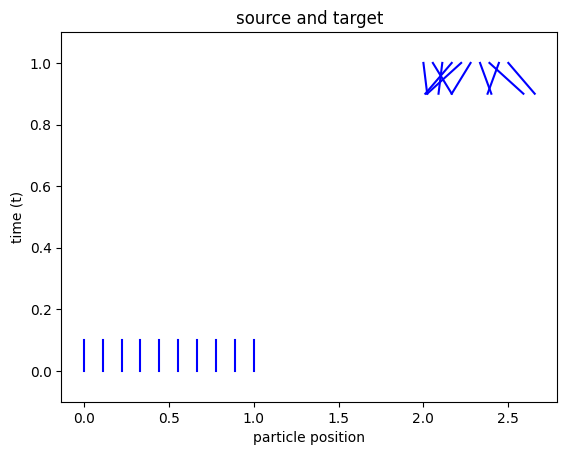

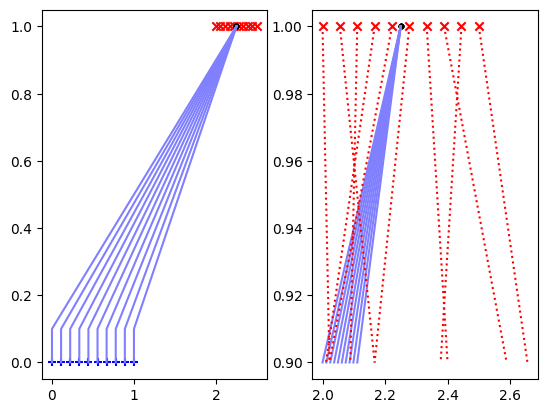

{'d': 1, 'dt': 0.1, 'L': 10, 'N': 10, 'delta': 0.3198895109691398, 'eps': 0.001, 'lr': 5e-06, 'n': 2000000}
1000


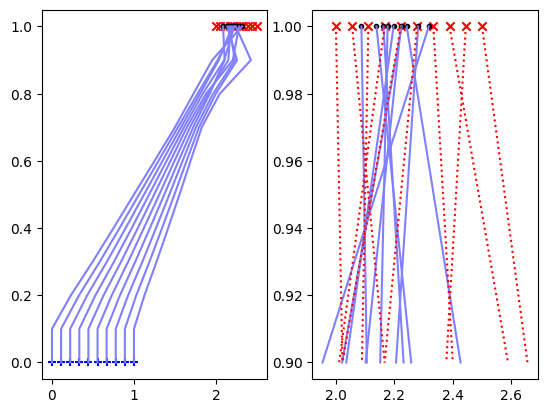

10000


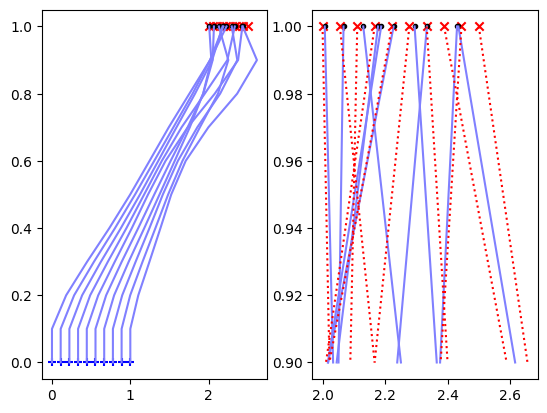

20000


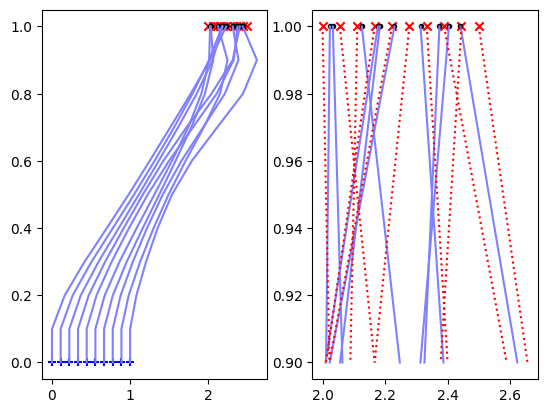

50000


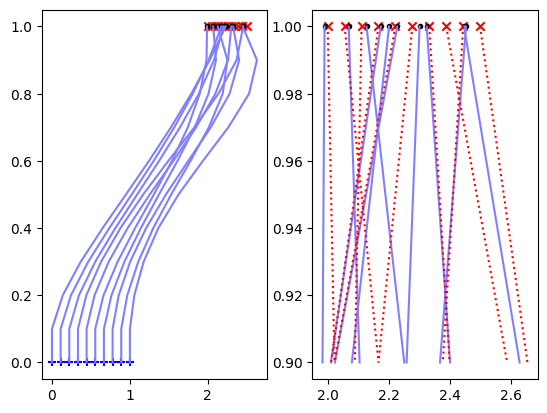

100000


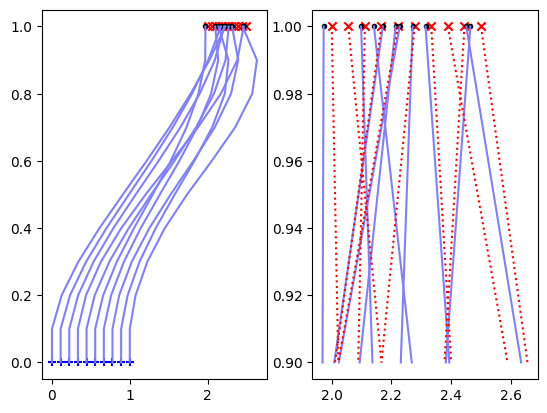

200000


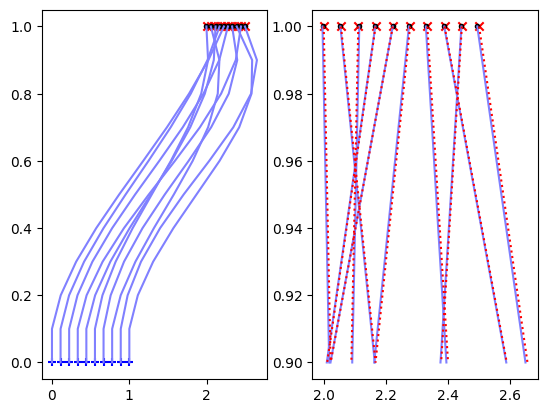

300000


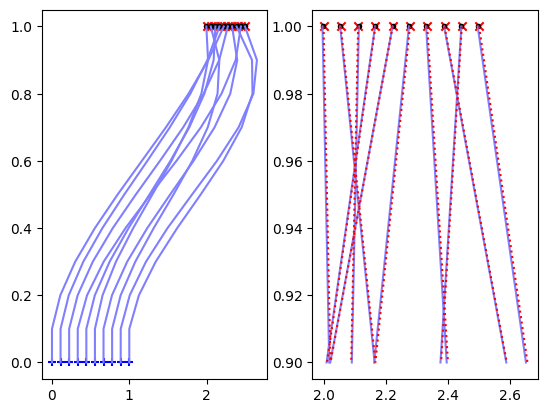

400000


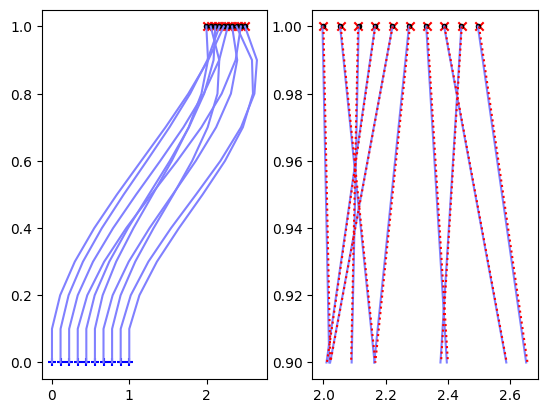

500000


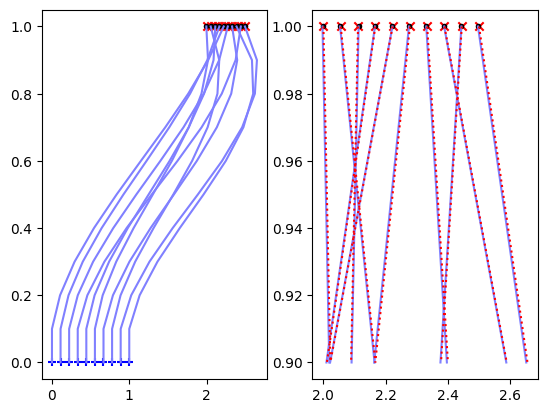

600000


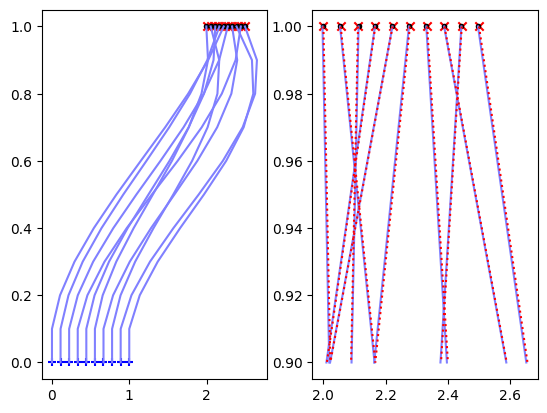

700000


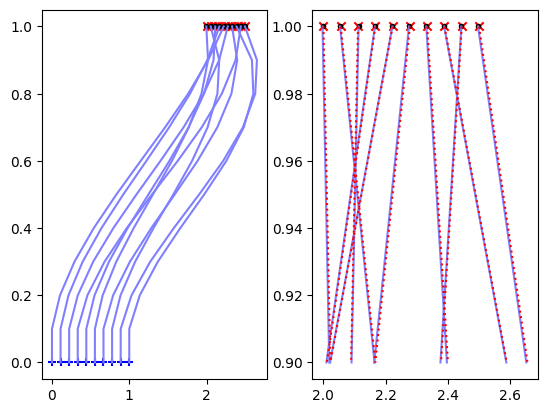

800000


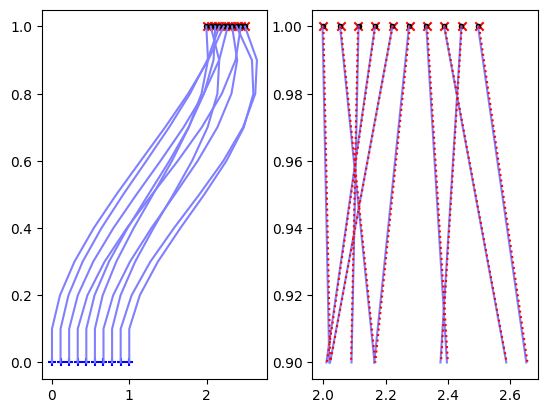

900000


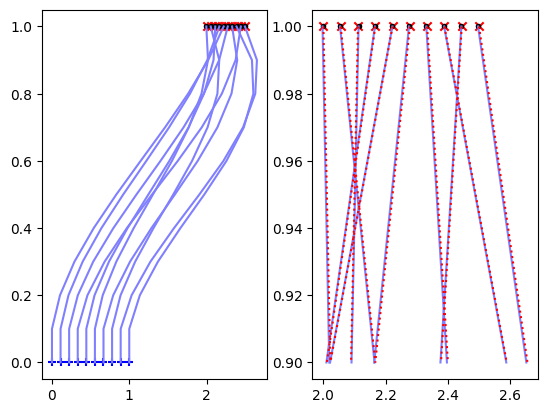

1000000


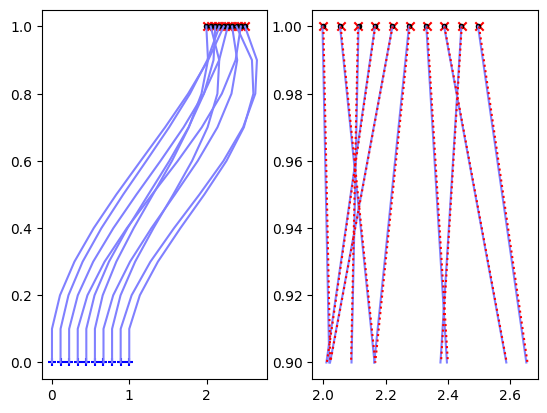

1100000


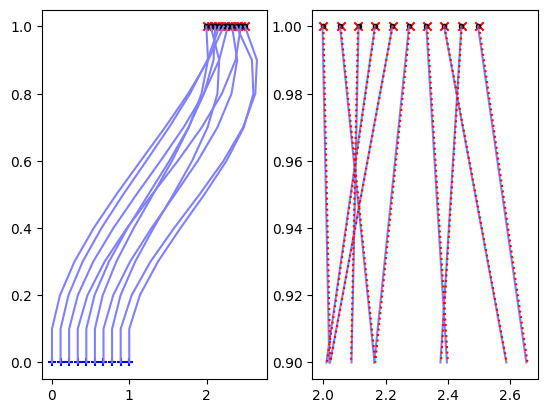

1200000


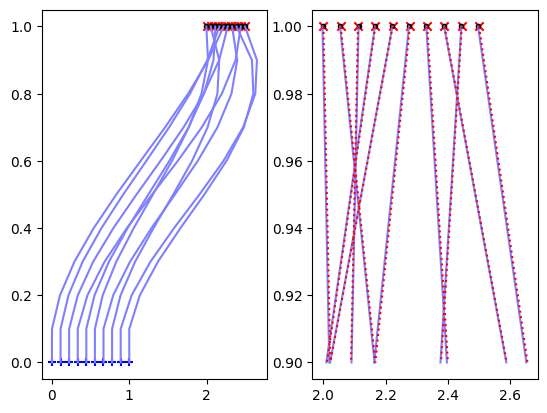

1300000


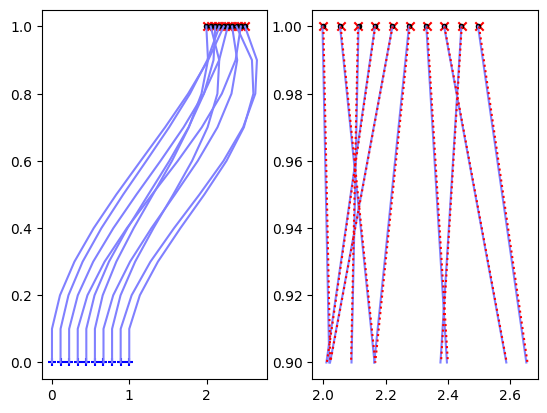

Epoch 1346555: reducing learning rate of group 0 to 1.0000e-06.
Epoch 1346567: reducing learning rate of group 0 to 2.0000e-07.
Epoch 1346576: reducing learning rate of group 0 to 4.0000e-08.
Early stopping at 1346578 out of 2000000


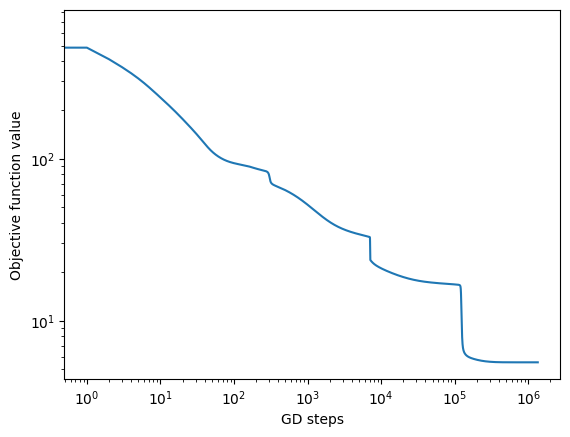

In [ ]:
lr = 5*eps/1e3
gd_steps = 2*int(1e6)

params.update({'lr': lr, 'n': gd_steps})

# target x(1), v(1)
x1 = np.linspace(2, 2.5, num=N).reshape(N, d)
v1 = np.linspace(-2, 2, num=N).reshape(N, d)
np.random.shuffle(v1)

w_tensor = torch.from_numpy(np.concatenate((x1, v1), axis=-1).astype(np.float64)).to(device)

# plot source and target
for p in range(N):
  plt.plot((x0[p], x_dt[p]), (0, dt), 'b')
  plt.plot((x1[p], x1[p]-dt*v1[p]), (1, 1-dt), 'b')
plt.title(r'source and target')
plt.ylabel('time (t)')
plt.xlabel('particle position')
plt.ylim([-dt, 1+dt])
plt.show()

# initialize at the middle
y0 = np.mean(x1)*np.ones_like(x1)
X0 = draw_straight_lines(x_dt, y0, params['L'])

plot_one_run(X0)

print(params)

# run gradient descent
m = Model(torch.from_numpy(X0.astype(np.float64)).to(device), w_tensor, z_tensor, params)
opt = torch.optim.SGD(m.parameters(), lr=params['lr'])
losses, res = training_loop(m, opt, n=params['n'])

X = m.X.data.cpu().detach().numpy()

# plot loss
plt.plot(losses)
plt.xlabel('GD steps')
plt.ylabel('Objective function value')
plt.xscale('log')
plt.yscale('log')
plt.show()

# save results
res[str(0)] = X0
res[str(gd_steps)] = X
res.update({'losses': losses, 'params': params, 'x0': x0, 'v0': v0, 'x1': x1, 'v1': v1})

with open(os.path.join(DRIVE_PATH, f'acceleration_random_{date}.pkl'), 'wb') as f:
  pickle.dump(res, f, protocol=pickle.HIGHEST_PROTOCOL)


# Plotting

In [ ]:
# from google.colab import drive
# import os
# drive.mount('/content/drive')
# DRIVE_PATH = "/content/drive/MyDrive/BlobOT-final"

# import sys
# sys.path.insert(0, DRIVE_PATH)

# import numpy as np
# import matplotlib.pyplot as plt
# import pickle

# import datetime
# date = datetime.datetime.today().strftime("%y%m%d")
# print(date)


dict_keys(['1000', '10000', '20000', '50000', '100000', '200000', '300000', '400000', '500000', '600000', '700000', '800000', '900000', '1000000', '0', 'losses', 'params', 'x0', 'v0', 'x1', 'v1'])


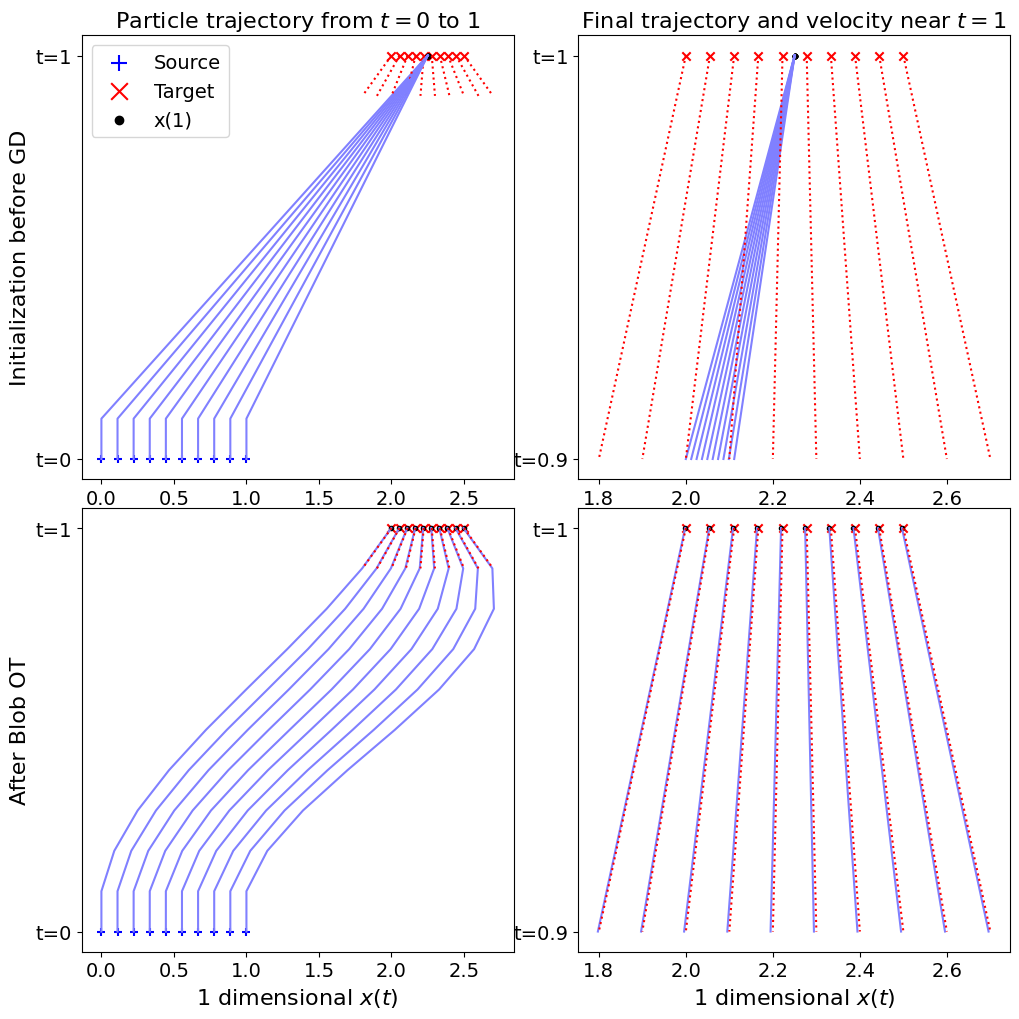

dict_keys(['1000', '10000', '20000', '50000', '100000', '200000', '300000', '400000', '500000', '600000', '700000', '800000', '900000', '1000000', '1100000', '1200000', '1300000', '0', '2000000', 'losses', 'params', 'x0', 'v0', 'x1', 'v1'])


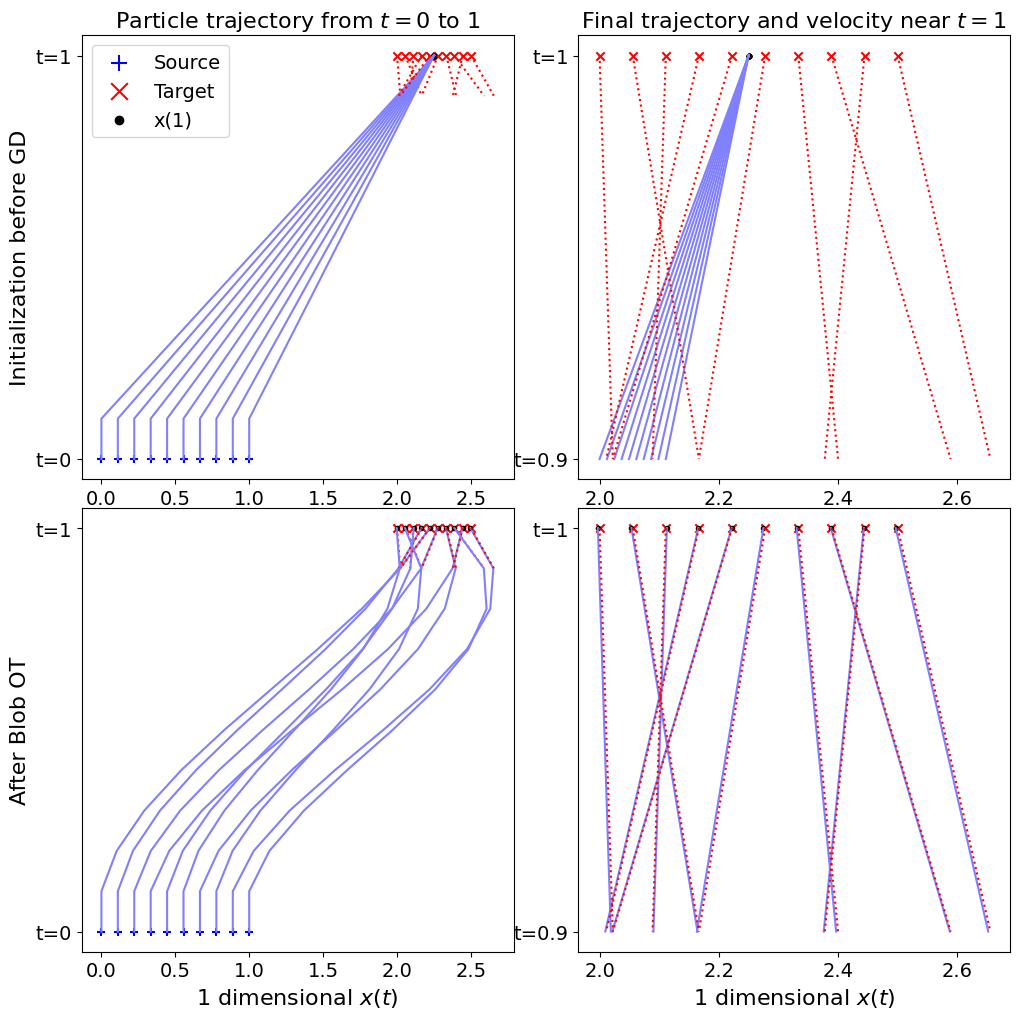

In [ ]:
for fn in [f'acceleration_{date}.pkl', f'acceleration_random_{date}.pkl']:
  with open(os.path.join(DRIVE_PATH, fn), 'rb') as f:
    res = pickle.load(f)
    print(res.keys())

    losses = res['losses']
    params = res['params']

    x0 = res['x0']
    v0 = res['v0']
    x1 = res['x1']
    v1 = res['v1']

  fig, ax = plt.subplots(2, 2, figsize=(5*2, 5*2))
  for i, eps in enumerate([0, params['n']]):
    X = res[str(eps)]

    if X.shape[-1] <= params['L']-1:
      x_dt = x0 + v0*params['dt']
      z = np.expand_dims(np.concatenate((x0, x_dt), axis=-1), axis=1) 
      X = np.concatenate((z, X), axis=-1)

    y = X[:, :, -1]
    t = params['dt']*np.arange(params['L']+1)

    # plot full trajectory
    for p in range(X.shape[0]):
      traj = X[p].T
      ax[i, 0].plot(traj[:, 0], t,  color=[.5, .5, 1])
      ax[i, 0].plot((x1[p], x1[p]-params['dt']*v1[p]), (1, 1-params['dt']), 'r:')

    ax[i, 0].scatter(X[:, 0, 0], np.zeros_like(X[:, 0, 0]), marker='+', c='b', label='Source')
    ax[i, 0].scatter(x1[:, 0], 1 + np.zeros_like(x1[:, 0]), marker='x', c='r', label='Target')
    ax[i, 0].scatter(y[:, 0], 1 + np.zeros_like(y[:, 0]), marker='.', c='k', label='x(1)')

    # zoom panel
    for p in range(X.shape[0]):
      traj = X[p].T
      ax[i, 1].plot(traj[-2:, 0], t[-2:],  color=[.5, .5, 1])

    ax[i, 1].scatter(x1[:, 0], 1 + np.zeros_like(x1[:, 0]), marker='x', c='r', label='Target')
    for p in range(X.shape[0]):
      ax[i, 1].plot((x1[p], x1[p]-params['dt']*v1[p]), (1, 1-params['dt']), 'r:')

    ax[i, 1].scatter(y[:, 0], 1 + np.zeros_like(y[:, 0]), marker='.', c='k', label='x(1)')

    # label things
    ax[i, 0].set_yticks([0, 1], ['t=0', 't=1'], fontsize=14)
    ax[i, 0].xaxis.set_tick_params(labelsize=14)
    ax[i, 1].set_yticks([0.9, 1], ['t=0.9', 't=1'], fontsize=14)
    ax[i, 1].xaxis.set_tick_params(labelsize=14)

    if i ==0:
      ax[i, 0].legend(fontsize=14, markerscale=2)
      ax[i, 0].set_ylabel('Initialization before GD', fontsize=16)
      ax[i, 0].set_title('Particle trajectory from $t=0$ to $1$', fontsize=16)
      ax[i, 1].set_title('Final trajectory and velocity near $t=1$', fontsize=16)
    else:
      ax[i, 0].set_ylabel('After Blob OT', fontsize=16)
      ax[i, 0].set_xlabel('1 dimensional $x(t)$', fontsize=16)
      ax[i, 1].set_xlabel('1 dimensional $x(t)$', fontsize=16)

  # link axes range
  for c in range(2):
    ylims = np.array([a.get_ylim() for a in ax[:, c]])
    xlims = np.array([a.get_xlim() for a in ax[:, c]])

    for cell in ax[:, c]:
      cell.set_ylim((ylims.min(axis=0)[0], ylims.max(axis=0)[1]))
      cell.set_xlim((xlims.min(axis=0)[0], xlims.max(axis=0)[1]))

  plt.tight_layout(pad=0)
  plt.savefig(os.path.join(DRIVE_PATH, fn[:-4]+'.pdf'), dpi=300)
  plt.show()